In [1]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [2]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

In [5]:
# setup helper for generating experiments (basically all sets of params to run through sim)
def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))


experiments = {
    "electorate_size": [10_000, 25_000, 50_000], # not O(n^2) with KDTree, but still bad
    "clusters": [1, 2, 10, 25],
    "cluster_std": [1, 2, 3],
    "electoral_system": ["majority", "plurality", "ranked"],
    "apathy_prob": [0, 0.01, 0.05],
    "candidates": np.arange(2, 10 + 1),
    "issues": np.arange(2, 25, 10, dtype=int),
}

columns = [*experiments.keys(), "fairness"]
records = []
experiment_matrix = list(generate_experiment_matrix(experiments))

for params in tqdm(experiment_matrix):
    
    # setup objects
    voters = electorate.setup_electorate(**params)
    parties = candidates.setup_candidates(**params, electorate=voters)
    system = voting_system.setup_voting_system(name=params["electoral_system"], **params)
    
    # simulate elections
    sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())
    
    result = sim.run()
    result_record = { 
        "fairness": round(result.unweighted_fairness, 3), **params 
    }
    result_record = {k: v for k, v in result_record.items() if k in columns}
    records.append(result_record)

100%|███████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


In [6]:
results_df = pd.DataFrame.from_records(records)
results_df

,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues
0,5.039,10000,1,1,majority,0,2,2
1,5.439,10000,1,1,majority,0,2,12
2,5.481,10000,1,1,majority,0,2,22
3,5.832,10000,1,1,majority,0,3,2
4,4.935,10000,1,1,majority,0,3,12
5,4.962,10000,1,1,majority,0,3,22
6,5.616,10000,1,1,majority,0,4,2
7,5.810,10000,1,1,majority,0,4,12
8,5.672,10000,1,1,majority,0,4,22
9,2.023,10000,1,1,majority,0,5,2


##### Store data or read from already performed experiment files

In [ ]:
filepath = "data/plurality-vs-majority-fa1cf6e7-7f2f-4f95-bfcc-2e41c06130e0.csv"

In [ ]:
# cache data so we don't need to start from scratch
assert not os.path.isfile(filepath), "data export already exists. Use a new uuid to prevent overwriting"
results_df.to_csv(filepath, index=False)
results_df = pd.read_csv(filepath)

In [ ]:
# read from cache 
results_df = pd.read_csv(filepath)

# Investigation of fairness between majority and pluralism

In [7]:
# generate correlation matrices for both different systems
majority = results_df.electoral_system == "majority"
plurality = results_df.electoral_system == "plurality"

In [8]:
majority_subset = results_df[majority].drop(["electoral_system"], axis=1) 
plurality_subset = results_df[plurality].drop(["electoral_system"], axis=1)

In [9]:
majority_subset

,fairness,electorate_size,clusters,cluster_std,apathy_prob,candidates,issues
0,5.039,10000,1,1,0,2,2
1,5.439,10000,1,1,0,2,12
2,5.481,10000,1,1,0,2,22
3,5.832,10000,1,1,0,3,2
4,4.935,10000,1,1,0,3,12
5,4.962,10000,1,1,0,3,22
6,5.616,10000,1,1,0,4,2
7,5.810,10000,1,1,0,4,12
8,5.672,10000,1,1,0,4,22
9,2.023,10000,1,1,0,5,2


In [10]:
# vector of correlation with fairness for both systems
majority_corr_record = dict(**majority_subset.corrwith(majority_subset.fairness), **{"electoral_system": "majority"})
plurality_corr_record = dict(**plurality_subset.corrwith(plurality_subset.fairness), **{"electoral_system": "plurality"})

In [11]:
majority_corr_record

{'fairness': 1.0,
 'electorate_size': nan,
 'clusters': nan,
 'cluster_std': nan,
 'apathy_prob': nan,
 'candidates': -0.4755708254148025,
 'issues': 0.3027372951662682,
 'electoral_system': 'majority'}

In [12]:
# compose to make plotting easier
corr_df = pd.DataFrame.from_records([majority_corr_record, plurality_corr_record]).drop(["clusters", "fairness"], axis=1)

In [13]:
corr_df

,electorate_size,cluster_std,apathy_prob,candidates,issues,electoral_system
0,NaN,NaN,NaN,-0.475571,0.302737,majority
1,NaN,NaN,NaN,NaN,NaN,plurality


In [25]:
# convert to long to enable bar plot
long_corr_cols = ["measure", "value", "electoral_system"]
long_corr_df = pd.DataFrame(columns=long_corr_cols)

for system in ["majority", "plurality"]:
    for measure in corr_df.columns:   
        for value in corr_df[ corr_df.electoral_system == system ][measure]:
            row = pd.DataFrame.from_records([{ "measure": measure, "value": value, "electoral_system": system }])
            long_corr_df = pd.concat([long_corr_df, row])
        
long_corr_df = long_corr_df.reset_index().drop("index", axis=1).drop([4, 9], axis=0)

In [26]:
long_corr_df

,measure,value,electoral_system
0,electorate_size,NaN,majority
1,cluster_std,NaN,majority
2,apathy_prob,NaN,majority
3,candidates,-0.475571,majority
5,electoral_system,majority,majority
6,electorate_size,NaN,plurality
7,cluster_std,NaN,plurality
8,apathy_prob,NaN,plurality
10,issues,NaN,plurality
11,electoral_system,plurality,plurality


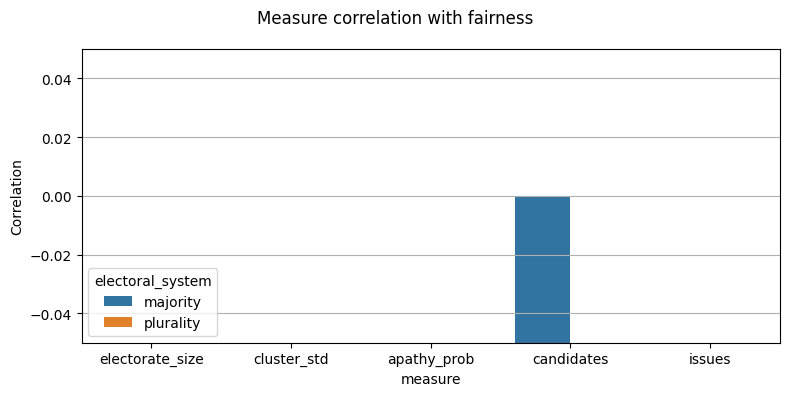

In [24]:
# drop the odd rows with non numerical value and plot
cleaned_long_corr = long_corr_df.drop([5, 11], axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
sns.barplot(data=cleaned_long_corr, x="measure", y="value", hue="electoral_system", ax=ax1)
ax1.set_ylim([-0.05, 0.05])
ax1.grid(axis="y")
ax1.set_ylabel("Correlation")
fig.suptitle("Measure correlation with fairness")
plt.show()

## Verify resuts via significance testing

In [17]:
import statsmodels.api as sm

In [18]:
# reusing prior wide representation with OLS model
# see https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

In [19]:
# before model, cast electoral_system to binary flag to enable regression
results_df["majority_electoral_system"] = results_df.electoral_system.map(lambda x: int(x == "majority"))

In [20]:
results_df

,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,majority_electoral_system
0,5.039,10000,1,1,majority,0,2,2,1
1,5.439,10000,1,1,majority,0,2,12,1
2,5.481,10000,1,1,majority,0,2,22,1
3,5.832,10000,1,1,majority,0,3,2,1
4,4.935,10000,1,1,majority,0,3,12,1
5,4.962,10000,1,1,majority,0,3,22,1
6,5.616,10000,1,1,majority,0,4,2,1
7,5.810,10000,1,1,majority,0,4,12,1
8,5.672,10000,1,1,majority,0,4,22,1
9,2.023,10000,1,1,majority,0,5,2,1


In [21]:
target = "fairness"
features = [c for c in results_df.columns if c not in ["fairness", "electoral_system"]]
ols = sm.OLS(endog=results_df[target], exog=results_df[features]).fit()

In [22]:
ols.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fairness   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1.276
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.337
Time:                        18:49:05   Log-Likelihood:                -13.293
No. Observations:                  10   AIC:                             32.59
Df Residuals:                       7   BIC:                             33.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
electorate_size               0.0006      0.000      4.537      0.003       0.000       0.001
clusters                   6.286e-08   1.39e-08      4.537      0.003    3.01e-08    9.56e-08
cluster_std                6.286e-08   1.39e-08      4.537      0.003    3.01e-08    9.56e-08
apathy_prob                        0          0        nan        nan           0           0
candidates                   -0.4683      0.362     -1.295      0.236      -1.324       0.387
issues                        0.0267      0.043      0.626      0.551      -0.074       0.128
majority_electoral_system  6.286e-08   1.39e-08      4.537      0.003    3.01e-08    9.56e-08
==============================================================================
Omnibus:                        1.303   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                0.528
Skew:                          -0.550   Prob(JB):                        0.768
Kurtosis:                       2.759   Cond. No.                     4.36e+35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.27e-63. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""